# EL Zorro
Basic code to create a package that builds MOM masks for surveys
--------

In [1]:
from multiprocessing import cpu_count
from pathlib import Path

import cdshealpix
import dask.distributed
import hats
import hats.io.file_io
import lsdb
import mom_builder
import numpy as np
import pandas as pd
import pyarrow as pa
from astropy.coordinates import Angle, Latitude, Longitude
from astropy.table import Table
from hats.io.paths import pixel_catalog_file
from hats.pixel_math.spatial_index import SPATIAL_INDEX_COLUMN, spatial_index_to_healpix, healpix_to_spatial_index
from hats.pixel_tree.pixel_tree import PixelTree
from hats.pixel_tree.pixel_alignment import align_with_mocs
from hats.pixel_tree.pixel_alignment_types import PixelAlignmentType
from hats_import.catalog.arguments import ImportArguments as RuntimeArguments
from hats_import.pipeline import pipeline_with_client as hats_import_pipeline
from hats.pixel_math import HealpixPixel

import matplotlib.pyplot as plt
import hpgeom as hpg
import healpy as hp

from mocpy import MOC
from tqdm import tqdm

/ocean/projects/phy210048p/shared/hipscat/raw/hsc/pdr3/elzorro/cenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.Constants

In [2]:
HIGHEST_ORDER         = 15          # Smallest tiles to start with
SPLIT_ORDER           = 5           # Split building tasks into tiles of this order
# For COVERAGE_TYPE:
#    'hatscat' : uses the whole catalog. Must specify COVERAGE_ORDER and POINT_CATALOG_HATSCAT
#    'points_map' : uses a low-resolution coverage map. Must specify POINTS_MAP_FITS
COVERAGE_TYPE         = 'hatscat'
COVERAGE_ORDER        = 13           # Maximum order to use for coverage map
HIGHEST_HATS_ORDER    = 4            # Maximum order of hats partitions
HATS_PIXEL_THRESHOLD  = 10_000_000   # Maximum number of rows per hats partition
MOCPY_THREADS         = None         # Number of threads to use with mocpy
MOM_BUILDER_THREADS   = cpu_count()  # Number of threads to use with mom_builder
DASK_WORKERS          = cpu_count()  # Number of dask workers, for hats-import
DASK_WORKERS_COVERAGE = None         # Number of dask workers, for coverage map

In [3]:
VALUE_NP_DTYPE = np.dtype(np.uint8)  # dtype object is required by mom_builder
VALUE_PA_TYPE  = pa.from_numpy_dtype(VALUE_NP_DTYPE)
VALUE_COLUMN   = 'value'  # Name of the value column in the output Hatscat

In [4]:
# Region files for brigth stars, boxes and dip circles
REGION_DIR    = Path('/ocean/projects/phy210048p/shared/hipscat/raw/hsc/pdr3/bright-object-masks')
BOX_REGIONS   = REGION_DIR / 'box.reg.I'
DIP_REGIONS   = REGION_DIR / 'dip.reg.I.nodups'
STARS_REGIONS = REGION_DIR / 'stars.reg.I.nodups'

# For COVERAGE_TYPE == 'hatscat'
POINT_CATALOG_HATSCAT = Path('/ocean/projects/phy210048p/shared/hsc_hatsv/hsc-pdr3-forced-i/')
# For COVERAGE_TYPE == 'points_map'
POINTS_MAP_FITS = Path('./hsc-pdr3-forced-r_points_map.fits')  # Coverage map distributed with hats

MOM_DIR = Path('./mom_parquet') # MOM tiles dir
HATS_DIR = Path('./hatscat')    # Ouput dir
HATS_NAME = 'hsc_pdr3_mask_i'   # Ouput mask

## 2.Read ascii region files and convert to healpix tiles of `HIGHEST_ORDER`

In [5]:
def read_circles(filename):
    table = Table.read(filename, format='ascii', names=['ra', 'dec', 'radius'], units=['deg']*3)
    ra = Longitude(table['ra'])
    dec = Latitude(table['dec'])
    radius = Angle(table['radius'])
    
    mocs = MOC.from_cones(lon=ra, lat=dec, radius=radius,
        max_depth=HIGHEST_ORDER, n_threads=MOCPY_THREADS)
    
    hp_index = np.concatenate([moc.flatten() for moc in mocs])
    return hp_index


def read_boxes(filename):
    table = Table.read(filename, format='ascii', names=['ra_c', 'dec_c', 'width', 'height'], units=['deg']*4)
    ra_center = Longitude(table['ra_c'])
    dec_center = Latitude(table['dec_c'])
    width = Angle(table['width'])
    height = Angle(table['height'])
    
    width_larger = width > height
    a = np.where(width_larger, 0.5 * width, 0.5 * height)
    b = np.where(width_larger, 0.5 * height, 0.5 * width)
    angle = np.where(width_larger, Angle(90, 'deg'), 0)
    
    mocs = MOC.from_boxes(lon=ra_center, lat=dec_center, a=a, b=b, angle=angle, 
                          max_depth=HIGHEST_ORDER, n_threads=MOCPY_THREADS)
    
    hp_index = np.concatenate([moc.flatten() for moc in mocs])
    return hp_index

In [6]:
#%time dip_index = read_circles(DIP_REGIONS)
%time stars_index = read_circles(STARS_REGIONS)
%time box_index = read_boxes(BOX_REGIONS)

CPU times: user 2min 32s, sys: 3min 53s, total: 6min 25s
Wall time: 1min 21s
CPU times: user 42.3 s, sys: 1.45 s, total: 43.8 s
Wall time: 4.36 s


### Group masks by pixels of `SPLIT_ORDER`

In [7]:
def parent(index, child_order, parent_order):
    delta_order = np.array(child_order - parent_order, dtype=np.int64)
    assert np.all(delta_order >= 0), 'parent_order must not be lower than the child_order'
    # For some numpyish reason, we cannot just do >>
    shift_bits = np.array(2, dtype=np.int64) * delta_order
    return np.right_shift(np.array(index, dtype=np.int64), shift_bits)

def first_child(index, parent_order, child_order):
    delta_order = np.array(child_order - parent_order, dtype=np.int64)
    assert np.all(delta_order >= 0), 'parent_order must not be lower than the child_order'
    # For some numpyish reason, we cannot just do <<
    shift_bits = np.array(2, dtype=np.int64) * delta_order
    return np.left_shift(np.array(index, dtype=np.int64), shift_bits)

def children(index, parent_order, child_order):
    delta_order = child_order - parent_order
    assert delta_order >= 0, 'parent_order must not be lower than the child_order'
    first = first_child(index, parent_order, child_order)
    n_children = 4 ** delta_order
    children = first.reshape(-1, 1) + np.arange(n_children, dtype=np.int64)
    return children.reshape(-1)

def group_by_order(hp_index, hp_order, split_order):
    # Sort and get unique indexes
    hp_index = np.unique(hp_index)
    
    split_order_npix = 12 * (4 ** split_order)
    split_order_indexes = np.arange(1, split_order_npix, dtype=np.int64)
    hp_order_separation_indexes = first_child(split_order_indexes, split_order, hp_order)
    
    # Split input indexes by the location in split_order tiles
    split_tile_boundaries = np.searchsorted(hp_index, hp_order_separation_indexes)
    lookup = np.split(hp_index, split_tile_boundaries)
    
    return lookup

In [8]:
%%time
#dip_lookup = group_by_order(dip_index, HIGHEST_ORDER, SPLIT_ORDER)
#del dip_index
stars_lookup = group_by_order(stars_index, HIGHEST_ORDER, SPLIT_ORDER)
del stars_index
box_lookup = group_by_order(box_index, HIGHEST_ORDER, SPLIT_ORDER)
del box_index

CPU times: user 3.69 s, sys: 180 ms, total: 3.87 s
Wall time: 4.03 s


## 3. Prepare coverage map

Type of the source data is specified by `COVERAGE_TYPE`:
- `COVERAGE_TYPE = 'points_map'` uses `points_map.fits` built during hats-import process, it is a low-resolution but fast method
- `COVERAGE_TYPE = 'hatscat'` uses the whole point-source hats catalog to built a coverage map with specified `COVERAGE_ORDER`

In [9]:
%%time

def process_points_map():
    coverage = hats.io.file_io.read_fits_image(POINTS_MAP_FITS)
    # Convert coverage to bool and then convert to the target type
    coverage = np.asarray(coverage > 0, dtype=VALUE_NP_DTYPE)

    # next I bascially copy HealpixDataset._read_moc_from_point_map()
    # https://github.com/astronomy-commons/hipscat/blob/04596506011ec5f021ebe612dcf7f5e8e9044795/src/hipscat/catalog/healpix_dataset/healpix_dataset.py#L114
    
    # length of the file is 12 * 4**order
    coverage_order_float = 0.5 * np.log2(coverage.shape[0] / 12)
    coverage_order = int(coverage_order_float)
    assert coverage_order == coverage_order_float, 'coverage_order must be an integer'
    assert coverage_order <= HIGHEST_ORDER, 'coverage_order is larger than HIGHEST_ORDER, cast coverage map to HIGHEST_ORDER'
    
    return coverage, coverage_order


class Coverage:
    def __init__(self, hats_catalog, split_order):
        self.hats_catalog = hats_catalog
        self.split_order = split_order
        
        self.pixel_mapping = self._pixel_mapping(hats_catalog, split_order)
        
        # import os
        # from itertools import chain
        # for path in chain.from_iterable(self.pixel_mapping):
        #     if path is None:
        #         continue
        #     assert os.path.exists(path)
    
    @staticmethod
    def _pixel_mapping(hats_catalog, split_order):
        split_order_tiles = np.arange(12 * 4**split_order)
        split_order_ranges = np.stack(
            [split_order_tiles, split_order_tiles + 1],
            axis=-1
        )
        split_order_tree = PixelTree(split_order_ranges, split_order)
        pixel_alignment = align_with_mocs(
            left_tree=split_order_tree,
            right_tree=hats_catalog.pixel_tree,
            left_moc=None,
            right_moc=hats_catalog.moc,
            alignment_type=PixelAlignmentType.LEFT,
        )
        mapping_df = pixel_alignment.pixel_mapping.copy()
        mapping_df['join_path'] = mapping_df.apply(
            lambda row: pixel_catalog_file(
                hats_catalog.catalog_base_dir, HealpixPixel(row["join_Norder"], row["join_Npix"])    # REPLACED WITH HealpixPixel()
            ) if row['join_Norder'] is not None else None,
            axis=1,
        )
        #mapping_df['join_path'] = mapping_df.apply(
        #    lambda row: pixel_catalog_file(
        #        hats_catalog.catalog_base_dir,
        #        row['join_Norder'],
        #        row['join_Npix']
        #    ) if row['join_Norder'] is not None else None,
        #    axis=1,
        #)
        # Series with index being [0..12 * 4**split_order)
        # and values to be a list of paritition paths in the catalog.
        # Each patition intersects with a given tile of split_order
        return mapping_df.groupby('primary_Npix')['join_path'].agg(
            lambda values: list(x for x in values if x is not None),
        )
    
    def get_split_tile(self, split_index, target_order):
        spatial_id_min = healpix_to_spatial_index(self.split_order, split_index)
        spatial_id_max = healpix_to_spatial_index(self.split_order, split_index + 1)
        
        paths = self.pixel_mapping[split_index]
        if len(paths) == 0:
            return np.array([], dtype=np.uint64)
        
        indexes = []
        for path in paths:
            df = hats.io.file_io.file_io.read_parquet_file_to_pandas(
                path,
                #storage_options=self.hats_catalog.storage_options,          # no storage_options in hats????
                # Load index only
                columns=[],
            )
            # filter pixels to be within given split tile
            # .loc[] does include end of the interval
            df = df.loc[spatial_id_min:spatial_id_max]
            
            spatial_id = df.index.to_numpy()
            target_index = np.unique(spatial_index_to_healpix(spatial_id, target_order))
            
            indexes.append(target_index.astype(np.uint64))

        return np.concatenate(indexes, dtype=np.uint64)


if COVERAGE_TYPE == 'points_map':
    coverage, coverage_order = process_points_map()
    
    def request_coverage(split_index):
        indexes_coverage_order = parent(first_index, HIGHEST_ORDER, coverage_order)
        return np.nonzero(coverage[indexes_coverage_order])[0].astype(np.uint64)
elif COVERAGE_TYPE == 'hatscat':
    assert COVERAGE_ORDER <= HIGHEST_ORDER, 'Coverage order must not be larger than highest order'
    
    hats_catalog = hats.read_hats(POINT_CATALOG_HATSCAT)
    coverage = Coverage(hats_catalog, SPLIT_ORDER)
    
    def request_coverage(split_index):
        coverage_order_index = coverage.get_split_tile(split_index, COVERAGE_ORDER)
        # Possible edge-case optimization
        # if COVERAGE_ORDER == HIGHEST_ORDER:
        #     return coverage_order_index
        return children(coverage_order_index, COVERAGE_ORDER, HIGHEST_ORDER).astype(np.uint64)
else:
    raise ValueError(f'Unknown COVERAGE_TYPE = "{COVERAGE_TYPE}"')

CPU times: user 3.09 s, sys: 119 ms, total: 3.2 s
Wall time: 4.58 s


In [10]:
hats_catalog.schema

id: int64
coord_ra: double
coord_dec: double
parent: int64
deblend_nChild: int32
base_SdssCentroid_x: double
base_SdssCentroid_y: double
base_SdssCentroid_xErr: float
base_SdssCentroid_yErr: float
base_TransformedCentroid_x: double
base_TransformedCentroid_y: double
base_InputCount_value: int32
base_SdssShape_xx: double
base_SdssShape_yy: double
base_SdssShape_xy: double
base_SdssShape_xxErr: float
base_SdssShape_yyErr: float
base_SdssShape_xyErr: float
base_SdssShape_x: double
base_SdssShape_y: double
base_SdssShape_instFlux: double
base_SdssShape_instFluxErr: double
base_SdssShape_psf_xx: double
base_SdssShape_psf_yy: double
base_SdssShape_psf_xy: double
base_SdssShape_instFlux_xx_Cov: float
base_SdssShape_instFlux_yy_Cov: float
base_SdssShape_instFlux_xy_Cov: float
base_TransformedShape_xx: double
base_TransformedShape_yy: double
base_TransformedShape_xy: double
modelfit_DoubleShapeletPsfApprox_0_xx: double
modelfit_DoubleShapeletPsfApprox_0_yy: double
modelfit_DoubleShapeletPsfAppr

In [11]:
# Just to explore what is inside mapping_df

split_oder = SPLIT_ORDER

split_order_tiles = np.arange(12 * 4**SPLIT_ORDER)
split_order_ranges = np.stack( [split_order_tiles, split_order_tiles + 1], axis=-1)
split_order_tree = PixelTree(split_order_ranges, SPLIT_ORDER)
pixel_alignment = align_with_mocs(
            left_tree=split_order_tree,
            right_tree=hats_catalog.pixel_tree,
            left_moc=None,
            right_moc=hats_catalog.moc,
            alignment_type=PixelAlignmentType.LEFT)
mapping_df = pixel_alignment.pixel_mapping.copy()

In [12]:
mapping_df

,primary_Norder,primary_Npix,join_Norder,join_Npix,aligned_Norder,aligned_Npix
0,5,0,None,None,5,0
1,5,1,None,None,5,1
2,5,2,None,None,5,2
3,5,3,None,None,5,3
4,5,4,None,None,5,4
...,...,...,...,...,...,...
13948,5,12283,None,None,5,12283
13949,5,12284,None,None,5,12284
13950,5,12285,None,None,5,12285
13951,5,12286,None,None,5,12286


## 4.Build Multi-Order Continious Map (MOM)

Define a function to get `HIGHEST_ORDER` tile values  =========================================================

In [13]:
def get_value(order, indexes):
    assert order == HIGHEST_ORDER
    
    first_index = indexes[0].astype(np.uint64)
    top_index = parent(first_index, HIGHEST_ORDER, SPLIT_ORDER)

    # Get HIGHEST_ORDER indexes and shift them to start from 0
    cover = request_coverage(top_index) - first_index
    #dip = dip_lookup[top_index] - first_index
    stars = stars_lookup[top_index] - first_index
    box = box_lookup[top_index] - first_index
    
    values = np.zeros(indexes.shape, dtype=VALUE_NP_DTYPE)
    
    # coverage is the first bit, coverage array is either 0 or 1
    values[cover] |= 1
    # Masks arrays can be safely shifted by the smallest index value
    # dip is the second bit
    #values[dip] |= 1 << 2
    # stars and their boxes is the third bit NO! // 2nd bit
    values[stars] |= 1 << 2
    values[box] |= 1 << 2
    
    return values

Define a MOM merging strategy ========================================================================

In [14]:
mom_merger = mom_builder.MOMMerger(
    # Each healpix tree leaf would have a single value
    # It is a coincidence that we have a column named 'value' 
    state='value',
    # If four children have the same value, they are merged into a single parent
    merger='equal',
    dtype=VALUE_NP_DTYPE,
)

Initialize parquet writer object ====================================================================

In [15]:
from writer import Writer

writer = Writer(
    MOM_DIR,
    col_name=VALUE_COLUMN,
    col_type=VALUE_PA_TYPE,
)

Run MOM building pipeline =========================================================================

In [16]:
%%time

generator = mom_builder.gen_mom_from_fn(
    fn=get_value,
    max_norder=HIGHEST_ORDER,
    split_norder=SPLIT_ORDER,
    merger=mom_merger,
    n_threads=MOM_BUILDER_THREADS,
    tiles_consumer=writer.write,  # immediately write tiles to parquet, output nothing from the generator
)

# Generator yields nothing, because tiles_consumer returns nothing
for _ in tqdm(generator, total=12 * 4**SPLIT_ORDER + 1):
    pass

#del dip_lookup, stars_lookup, box_lookup, coverage

100%|██████████| 12289/12289 [00:24<00:00, 507.09it/s] 

CPU times: user 8min 52s, sys: 12.5 s, total: 9min 5s
Wall time: 24.3 s


## 4. Create mask catalog with hats-import

In [18]:
%%time
hats_import_args = RuntimeArguments(
    input_path=MOM_DIR,
    file_reader='parquet',
    output_path=HATS_DIR,
    output_artifact_name=HATS_NAME,
    # We have _hipscat_index predefined, it points to the "beginning" of a tile
    # (smallest index within all order-19 children)
    use_healpix_29=True,
    add_healpix_29=False,
    highest_healpix_order=HIGHEST_HATS_ORDER,
    pixel_threshold=HATS_PIXEL_THRESHOLD,
    # Turn off optimization needed for point catalogs
    drop_empty_siblings=False,
)

with dask.distributed.Client(n_workers=DASK_WORKERS) as client:
    display(client)
    hats_import_pipeline(hats_import_args, client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 128
Total threads: 128,Total memory: 234.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41563,Workers: 128
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 234.38 GiB
Comm: tcp://127.0.0.1:34139,Total threads: 1
Dashboard: http://127.0.0.1:45931/status,Memory: 1.83 GiB
Nanny: tcp://127.0.0.1:40913,


Finishing : 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


CPU times: user 15.4 s, sys: 8.57 s, total: 24 s
Wall time: 35 s


## Load mask catalog with LSDB an do some plots

In [20]:
catalog = lsdb.read_hats(HATS_DIR / HATS_NAME).compute()

In [21]:
catalog

,pixel_Norder,pixel_Npix,value,Norder,Dir,Npix
_healpix_29,,,,,,
0,14,0,0,0,0,0
1073741824,14,1,0,0,0,0
2147483648,14,2,4,0,0,0
3221225472,15,12,0,0,0,0
3489660928,15,13,0,0,0,0
...,...,...,...,...,...,...
3458764491540398080,15,12884901805,0,0,0,11
3458764491808833536,15,12884901806,4,0,0,11
3458764492077268992,15,12884901807,0,0,0,11


In [22]:
np.unique(catalog['pixel_Norder'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=uint8)

In [23]:
np.unique(catalog['value'].values)

array([0, 1, 4, 5], dtype=uint8)

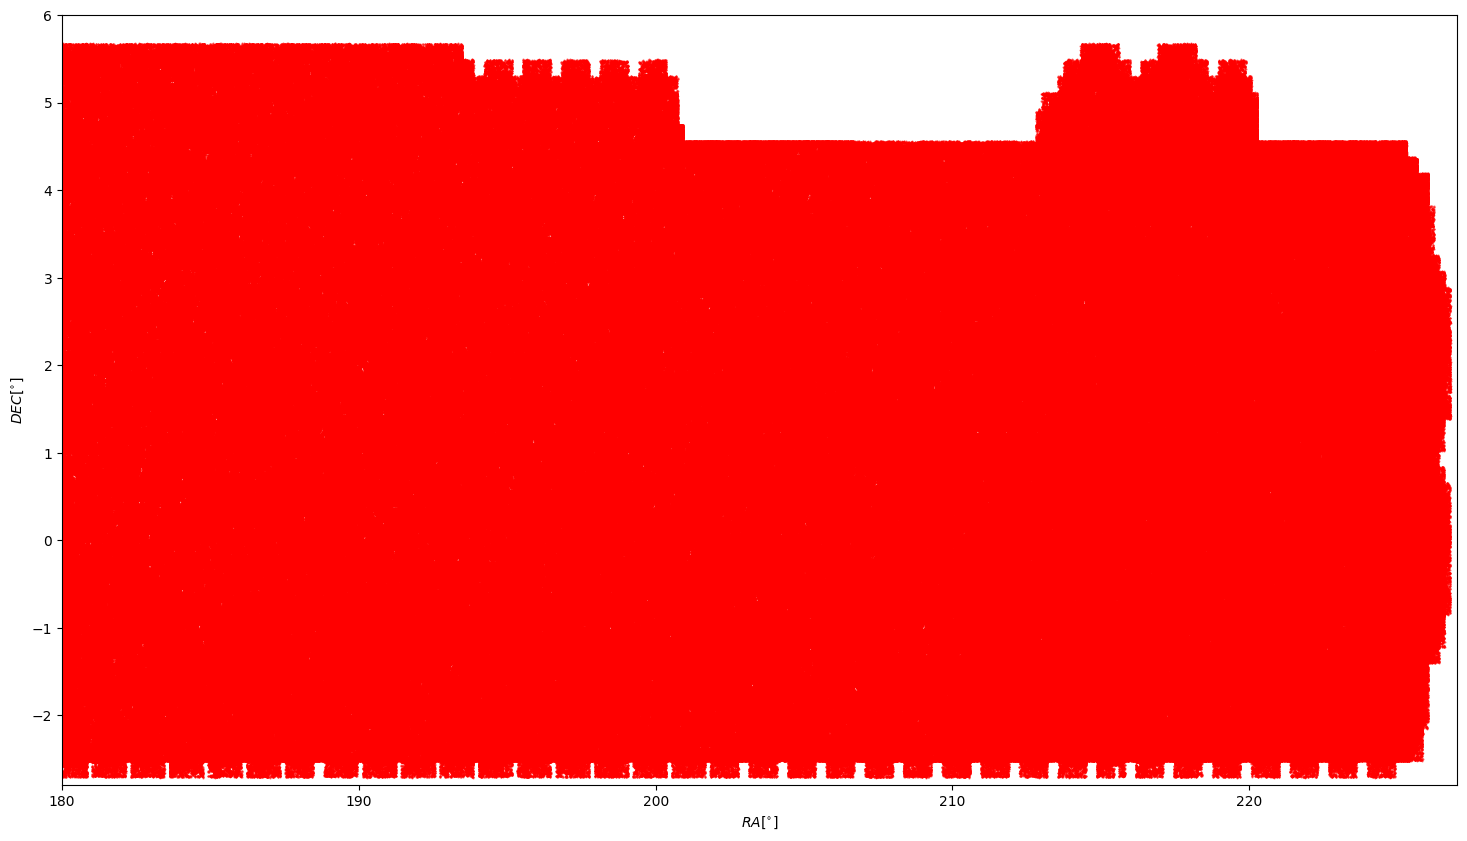

In [24]:
def to_plot(order_list, ra_min, ra_max, dec_min, dec_max):
    x = []
    y = []
    for order in order_list:
        nside = 2**order
        # Pixels to plot in each order
        pixels1 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 1)]['pixel_Npix'].values
        pixels2 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 5)]['pixel_Npix'].values
        #pixels3 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 13)]['pixel_Npix'].values
        pixels = np.concatenate((pixels1, pixels2))
        theta, phi = hp.pix2ang(int(nside), np.array(pixels, dtype=np.int64), nest=True)
        ra = np.degrees(phi)
        dec = 90.0 - np.degrees(theta)
        selected_coord = (ra >= ra_min) & (ra <= ra_max) & (dec >= dec_min) & (dec <= dec_max)
        selected_pixels = np.array(pixels)[selected_coord]
        bounds_lon, bounds_lat = hpg.boundaries(nside, 
                                                np.array(selected_pixels, dtype=np.int64),
                                                step=1, nest=True)
        x.append(np.ravel(bounds_lon))
        y.append(np.ravel(bounds_lat))
    return np.hstack(x), np.hstack(y)

order_list = [9, 10, 11, 12, 13]
ra_cen = 337.1
#ra_min = ra_cen - 1
#ra_max = ra_cen + 1
ra_min = 180
ra_max = 227
dec_cen = -0.05
#dec_min = dec_cen - 1
#dec_max = dec_cen + 1
dec_min = -2.8
dec_max = 6
x, y = to_plot(order_list, ra_min, ra_max, dec_min, dec_max)
plt.figure(figsize=(18,10))
plt.plot(np.hstack(x), np.hstack(y), 'r.', ms=1, alpha=0.5)
plt.xlim(ra_min, ra_max)
plt.ylim(dec_min, dec_max)
plt.xlabel(r"$RA [^{\circ}]$")
plt.ylabel(r"$DEC [^{\circ}]$")
plt.savefig('fig1.png')
plt.show()

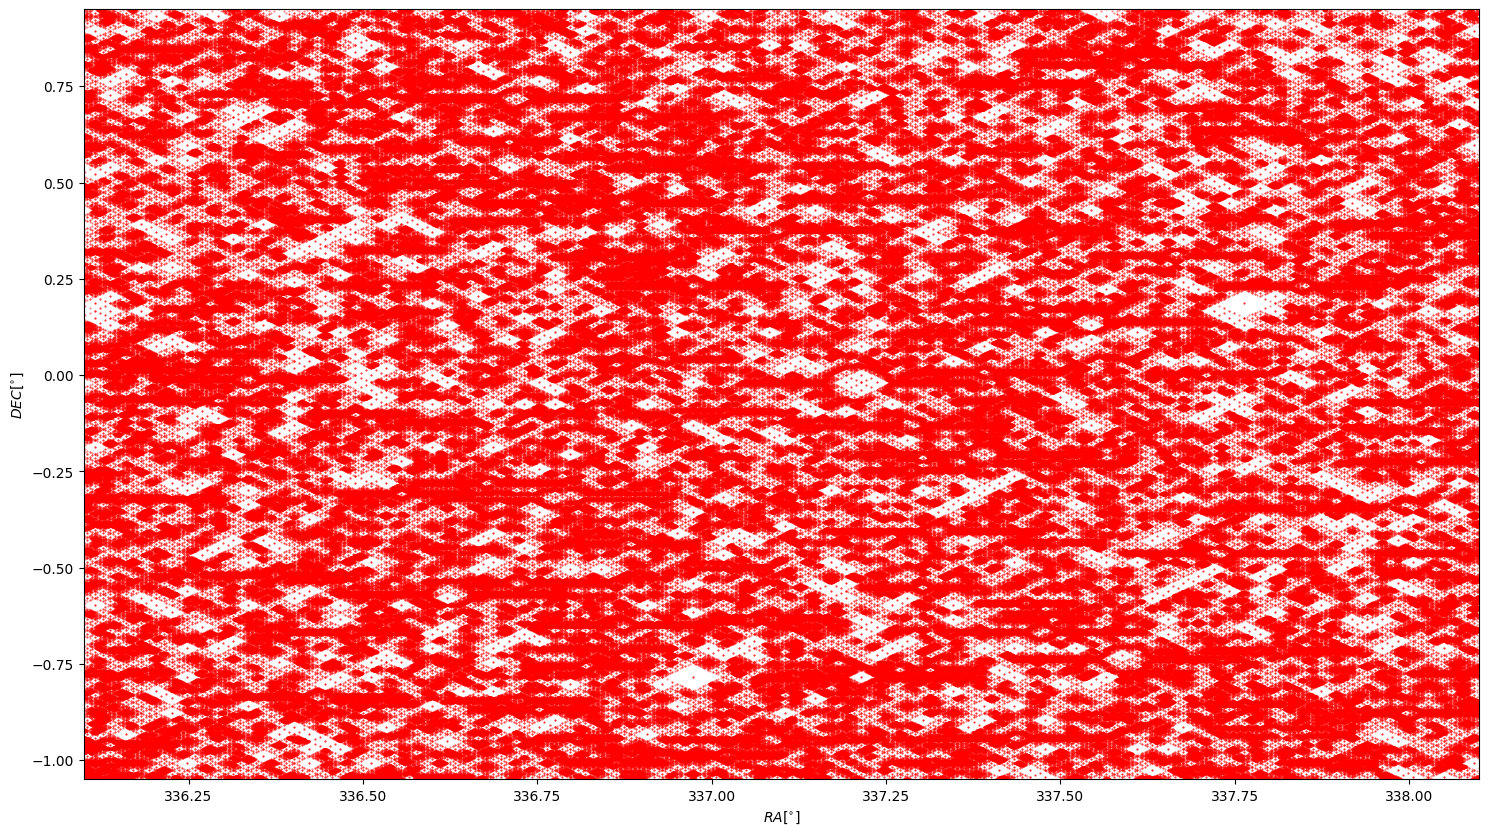

In [26]:
def to_plot(order_list, ra_min, ra_max, dec_min, dec_max):
    x = []
    y = []
    ra_pix_s = []
    dec_pix_s = []
    for order in order_list:
        nside = 2**order
        # Pixels to plot in each order
        pixels1 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 1)]['pixel_Npix'].values
        pixels2 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 5)]['pixel_Npix'].values
        #pixels2 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 13)]['pixel_Npix'].values
        pixels = np.concatenate((pixels1, pixels2))
        theta, phi = hp.pix2ang(int(nside), np.array(pixels, dtype=np.int64), nest=True)
        ra = np.degrees(phi)
        dec = 90.0 - np.degrees(theta)
        selected_coord = (ra >= ra_min) & (ra <= ra_max) & (dec >= dec_min) & (dec <= dec_max)
        selected_pixels = np.array(pixels)[selected_coord]
        ra_pix, dec_pix = hp.pix2ang(int(nside), np.array(selected_pixels, dtype=np.int64), lonlat=True, nest=True)
        bounds_lon, bounds_lat = hpg.boundaries(nside, 
                                                np.array(selected_pixels, dtype=np.int64),
                                                step=3, nest=True)
        ra_pix_s.append(np.ravel(ra_pix))
        dec_pix_s.append(np.ravel(dec_pix))
        x.append(np.ravel(bounds_lon))
        y.append(np.ravel(bounds_lat))
    return np.hstack(x), np.hstack(y), ra_pix_s, dec_pix_s

order_list = [10, 11, 12, 13, 14, 15, 16]
ra_cen = 337.1
ra_min = ra_cen - 1
ra_max = ra_cen + 1
dec_cen = -0.05
dec_min = dec_cen - 1
dec_max = dec_cen + 1
x, y, ra_pix, dec_pix = to_plot(order_list, ra_min, ra_max, dec_min, dec_max)
plt.figure(figsize=(18,10))
plt.plot(np.hstack(x), np.hstack(y), 'r.', ms=1, alpha=0.5)
plt.plot(np.hstack(ra_pix), np.hstack(dec_pix), 'r.', ms=1, alpha=1)
plt.xlim(ra_min, ra_max)
plt.ylim(dec_min, dec_max)
plt.xlabel(r"$RA [^{\circ}]$")
plt.ylabel(r"$DEC [^{\circ}]$")
plt.savefig('fig2.png')
plt.show()

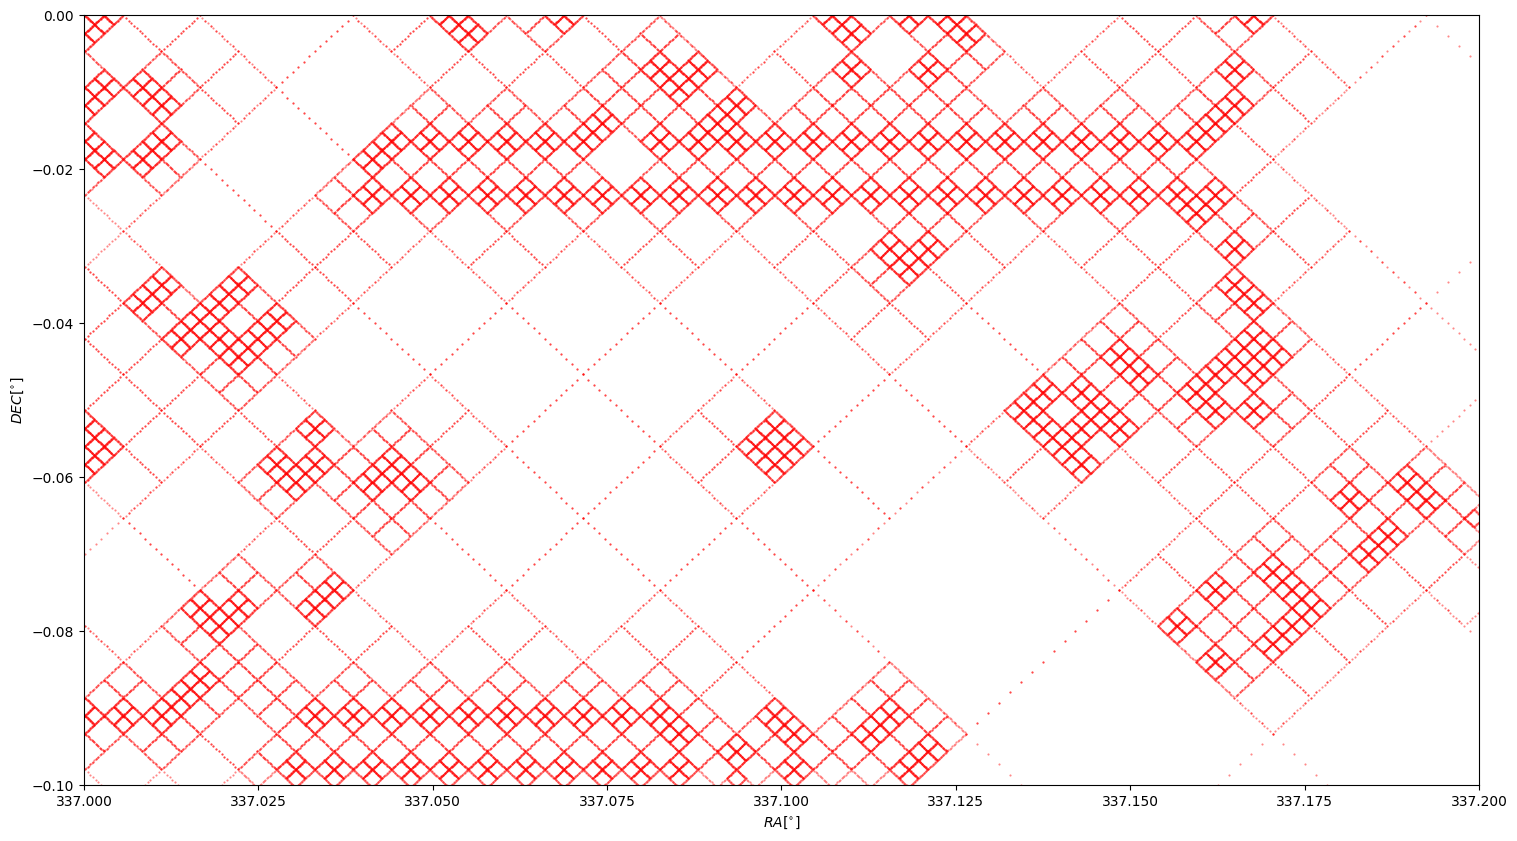

In [27]:
def to_plot(order_list, ra_min, ra_max, dec_min, dec_max):
    x = []
    y = []
    pixels_var = []
    for order in order_list:
        nside = 2**order
        # Pixels to plot in each order
        pixels1 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 1)]['pixel_Npix'].values
        pixels2 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 5)]['pixel_Npix'].values
        #pixels3 = catalog[(catalog['pixel_Norder'] == order) & (catalog['value'] == 13)]['pixel_Npix'].values
        pixels = np.concatenate((pixels1, pixels2))
        theta, phi = hp.pix2ang(int(nside), np.array(pixels, dtype=np.int64), nest=True)
        ra = np.degrees(phi)
        dec = 90.0 - np.degrees(theta)
        selected_coord = (ra >= ra_min) & (ra <= ra_max) & (dec >= dec_min) & (dec <= dec_max)
        selected_pixels = np.array(pixels)[selected_coord]
        bounds_lon, bounds_lat = hpg.boundaries(nside, 
                                                np.array(selected_pixels, dtype=np.int64),
                                                step=14, nest=True)
        x.append(np.ravel(bounds_lon))
        y.append(np.ravel(bounds_lat))
    return np.hstack(x), np.hstack(y)

order_list = [11, 12, 13, 14, 15, 16]
ra_min, ra_max = 337, 337.2
dec_min, dec_max = -0.1, 0.0
x, y = to_plot(order_list, ra_min, ra_max, dec_min, dec_max)
plt.figure(figsize=(18,10))
plt.plot(np.hstack(x), np.hstack(y), 'r.', ms=1, alpha=0.5)
plt.xlim(ra_min, ra_max)
plt.ylim(dec_min, dec_max)
plt.xlabel(r"$RA [^{\circ}]$")
plt.ylabel(r"$DEC [^{\circ}]$")
plt.savefig('fig3.png')
plt.show()

In [28]:
import hats
from hats.pixel_math import HealpixPixel
import os

catalog_dir = '/ocean/projects/phy210048p/shared/hsc_hatsv/hsc-pdr3-forced-i/'

info_frame = hats_catalog.partition_info.as_dataframe()

In [29]:
info_frame

,Norder,Npix
0,4,665
1,4,1095
2,4,1103
3,4,1128
4,4,1373
...,...,...
1602,10,2466815
1603,10,2506751
1604,10,2510847
1605,10,2527231


In [30]:
for index, partition in info_frame.iterrows():
    print(index)
    print(partition)
    print('---')

0
Norder      4
Npix      665
Name: 0, dtype: int64
---
1
Norder       4
Npix      1095
Name: 1, dtype: int64
---
2
Norder       4
Npix      1103
Name: 2, dtype: int64
---
3
Norder       4
Npix      1128
Name: 3, dtype: int64
---
4
Norder       4
Npix      1373
Name: 4, dtype: int64
---
5
Norder       4
Npix      1962
Name: 5, dtype: int64
---
6
Norder       5
Npix      1031
Name: 6, dtype: int64
---
7
Norder       5
Npix      1035
Name: 7, dtype: int64
---
8
Norder       5
Npix      1036
Name: 8, dtype: int64
---
9
Norder       5
Npix      1040
Name: 9, dtype: int64
---
10
Norder       5
Npix      1056
Name: 10, dtype: int64
---
11
Norder       5
Npix      2049
Name: 11, dtype: int64
---
12
Norder       5
Npix      2054
Name: 12, dtype: int64
---
13
Norder       5
Npix      2057
Name: 13, dtype: int64
---
14
Norder       5
Npix      2058
Name: 14, dtype: int64
---
15
Norder       5
Npix      2080
Name: 15, dtype: int64
---
16
Norder       5
Npix      2411
Name: 16, dtype: int64
---
17

In [31]:
for index, partition in info_frame.iterrows():
    file_name = result = hats.io.paths.pixel_catalog_file(
        catalog_dir, HealpixPixel(partition["Norder"], partition["Npix"])
    )
    info_frame.loc[index, "size_on_disk"] = os.path.getsize(file_name)

info_frame = info_frame.astype(int)
info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)

In [32]:
HealpixPixel(4, 1095).pixel

1095

In [33]:
HealpixPixel(4, '1095').order

4